In [1]:
import NBHD
import dataset_utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim

from pytorch_metric_learning import distances, losses, miners, reducers


def get_Cosine_margin(model, x_test, y_test=None):
    def cosine_distance(a, b):
        return 1 - torch.cosine_similarity(a[:, np.newaxis, :], b, dim=-1)
    
    # Compute test samples' Hamming distance
    class_hvs = model.class_hvs.data
    test_enc_hvs = model.encoding(x_test)
    test_Cosine_dist = cosine_distance(test_enc_hvs, class_hvs)

    sorted_test_Cosine_distance, _ = torch.sort(test_Cosine_dist, dim=-1, descending=False)
    test_enc_hvs_Cosine_margin = (sorted_test_Cosine_distance[:,1:]-sorted_test_Cosine_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cuda()
    mean_test_Cosine_margin = torch.mean(test_enc_hvs_Cosine_margin).item()

    return mean_test_Cosine_margin

def get_Hamming_margin(model, x_test, y_test=None):
	def Hamming_distance(a, b):
		D = a.size()[1]
		return (D - a @ b.T)/2

	# # Compute mean Hamming distance between class HVS
	class_hvs = model.quantize_class_hvs(model.class_hvs.data, soft = False)
	# class_Hamming_distance = Hamming_distance(class_hvs, class_hvs)
	# mean_class_Hamming_distance = torch.mean(class_Hamming_distance).item()
	

	# Compute test samples' Hamming distance
	test_enc_hvs = model.encoding(x_test, soft = False)
	test_Hamming_dist = Hamming_distance(test_enc_hvs, class_hvs)

	sorted_test_Hamming_distance, _ = torch.sort(test_Hamming_dist, dim=-1, descending=False)
	test_enc_hvs_Hamming_margin = (sorted_test_Hamming_distance[:,1:]-sorted_test_Hamming_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cuda()
	mean_test_Hamming_margin = torch.mean(test_enc_hvs_Hamming_margin).item()

	return mean_test_Hamming_margin

def HD_test(model, x_test, y_test):
    out = model(x_test, embedding=False)
    preds = torch.argmax(out, dim=-1)

    acc = torch.mean((preds==y_test).float())	
    return acc

def test_quantizer(dataset, D = 1000, levels = 3, m=10, HD_lr = 0.05, metric_lr = 0.01, enc_type='RP', similarity_type = "cosine"):
    nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader\
        = dataset_utils.load_dataset(dataset, 256, "cuda")
    model = NBHD.HDC(dim = nFeatures, D=D, num_classes=nClasses, m=m, levels=levels, enc_type=enc_type, similarity_type= similarity_type)
    model.init_class(x_train, y_train)

    def plot_quant(label):
        x = torch.linspace( model.quantize_data.weights[0].item() - 5, model.quantize_data.weights[len(model.quantize_data.weights) - 1].item() + 5 , 1000)
        y1 = model.quantize_data(x, soft = False)
        y2 = model.quantize_data(x, soft = True).detach()
        
        plt.plot(x, y1, c="red", label = "Hard Quantization")
        plt.plot(x, y2, c="blue", label = "Soft Quantization")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Quantize function over learning operations. Levels: {}, Iteration:{}".format(levels, label))
        plt.legend()
        plt.show()

        sns.displot(model.class_hvs_nq.flatten().detach())
        for weight in model.quantize_class_hvs.weights.detach():
            plt.axvline(weight, ls="--", c = "red")
        plt.title("non-quantized class_hvs distribution")
        plt.show()
        sns.displot(model.class_hvs.flatten().detach())
        plt.title("quantized class_hvs distribution")
        plt.show()
        
        

        y3 = model.encoding(x_test, quantize=False).flatten().detach()
        y4 = model.quantize_data(y3, soft = False)
        sns.displot(y3)
        plt.title("encoding distribution")
        for weight in model.quantize_data.weights.detach():
            plt.axvline(weight, ls="--", c = "red")
        plt.show()
        sns.displot(y4)
        plt.title("encoding quantization distribution")
        plt.show()
        for name, param in model.named_parameters():
            if("quant" in name):
                print(name, param.data)
    
    #plot_quant(0)
    

    accuracies = []
    accuracies.append(HD_test(model, x_test, y_test).item())
    margins = []
    margins.append(get_Cosine_margin(model, x_test, y_test))

    # device = "cpu"
    # num_metric_epochs = 0
    # metric_lr = metric_lr
    # model.class_hvs = nn.parameter.Parameter(data=model.class_hvs)
    # optimizer = optim.Adam(model.parameters(), lr=metric_lr)
    # distance = distances.CosineSimilarity()

    # reducer = reducers.ThresholdReducer(low=0.0)
    # loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
    # mining_func = miners.TripletMarginMiner(
    #     margin=0.2, distance=distance, type_of_triplets="semihard", )

    # ### pytorch-metric-learning stuff ###
    # for epoch_i in range(1, num_metric_epochs + 1):
    #     NBHD.metric_train(model, loss_func, mining_func, device, train_loader, optimizer, epoch_i)
    #     accuracies.append(HD_test(model, x_test, y_test).item())
    #     margins.append(get_Cosine_margin(model, x_test, y_test))
    #     # for name, param in model.named_parameters():
    #     #     if("quant" in name):
    #     #         print(name, param.data)

    num_HD_epoch = 20

    for epoch_i in range(1, num_HD_epoch+1):
        model.HD_train_step(x_train, y_train, lr=HD_lr)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Cosine_margin(model, x_test, y_test))

    # if(num_metric_epochs > 0):
    #     plot_quant(num_metric_epochs)

    
    plt.plot(accuracies, label="Accuracy", c = "blue")
    plt.plot(margins, label="Margins", c="cyan")
    plt.xlabel("iterations")
    plt.ylabel("accuracy")
    #plt.axvline(x=15, c= "red" , ls="--")
    plt.title("Accuracy of {} Levels, {} Dimensions, Dataset:{}".format(levels, D, dataset))
    plt.legend()
    plt.show()
    print("Maximum Accuracy:{}".format(max(accuracies)))

    #plot_quant("End")
    #print('Level:',level," Metric_lr:",metric_lr, " Accuracies:" ,accuracies, "Margins:", margins)
    return accuracies

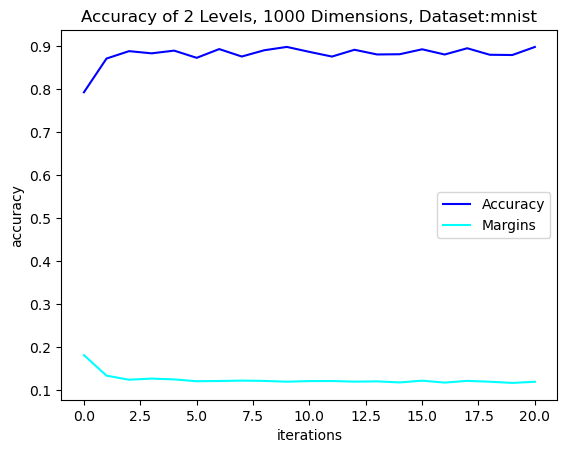

Maximum Accuracy:0.8973999619483948


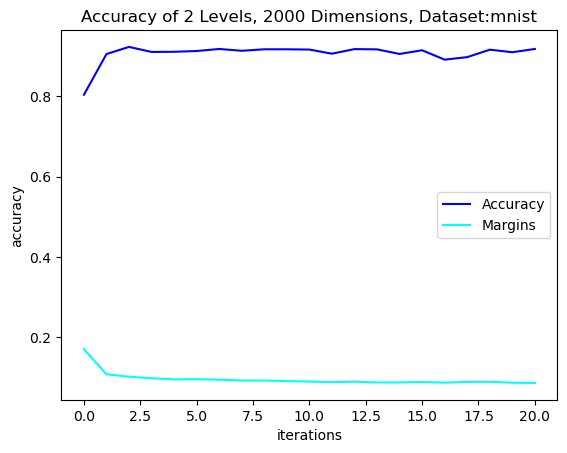

Maximum Accuracy:0.9226999878883362


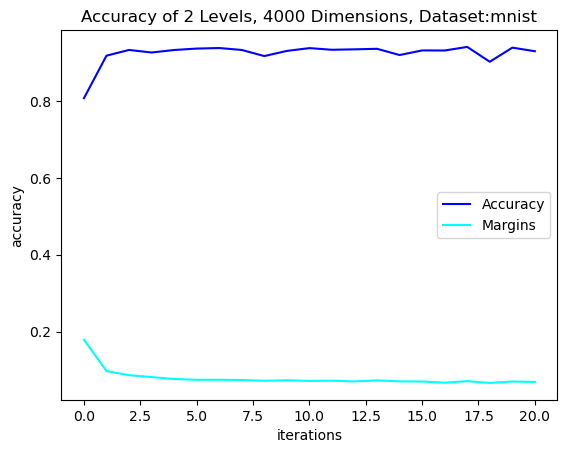

Maximum Accuracy:0.9406999945640564
{('mnist', 2): [0.8073999881744385, 0.9179999828338623, 0.9327999949455261, 0.9261999726295471, 0.932699978351593, 0.9363999962806702, 0.9377999901771545, 0.9327999949455261, 0.9168999791145325, 0.9302999973297119, 0.9375999569892883, 0.9332999587059021, 0.9343999624252319, 0.9357999563217163, 0.9195999503135681, 0.9315999746322632, 0.9314000010490417, 0.9406999945640564, 0.9020999670028687, 0.9387999773025513, 0.9294999837875366]}


In [2]:
datasets = ["mnist"]
levels = [2]
metric_lrs = [0.0001]
HD_lrs =[1]
accs = {}
dimensions = [1000, 2000, 4000]
for dataset in datasets:
    for level in levels:
        for HD_lr in HD_lrs:
            for metric_lr in metric_lrs:
                for dimension in dimensions:
                    acc = test_quantizer(dataset=dataset,levels = level, D = dimension, metric_lr = metric_lr ,HD_lr=HD_lr, enc_type="RP", similarity_type = "hamming")
                    accs[(dataset, level)] = acc

print(accs)